<a href="https://colab.research.google.com/github/zzNuAzz/Image-Stiching-IMG/blob/master/Panorama.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Chuẩn bị thư viện**
- Reinstall lại OpenCV do từ bản mới đã không hỗ trợ SIFT (thuật toán để detect các keypoints được sử dụng trong bài toán này)
- Đọc data từ github

In [1]:
!pip uninstall opencv-python -y
!pip install opencv-contrib-python==3.4.2.17 --force-reinstall
!git clone https://github.com/zzNuAzz/Image-Stiching-IMG.git "/content/data"

Uninstalling opencv-python-4.1.2.30:
  Successfully uninstalled opencv-python-4.1.2.30
     |████████████████████████████████| 30.6MB 86kB/s 
     |████████████████████████████████| 15.3MB 117kB/s 
ERROR: imgaug 0.2.9 requires opencv-python, which is not installed.
ERROR: dopamine-rl 1.0.5 requires opencv-python>=3.4.1.15, which is not installed.
ERROR: albumentations 0.1.12 requires opencv-python, which is not installed.
ERROR: tensorflow 2.4.1 has requirement numpy~=1.19.2, but you'll have numpy 1.20.3 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Suc

Cloning into '/content/data'...
remote: Enumerating objects: 51, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 51 (delta 1), reused 48 (delta 1), pack-reused 0
Unpacking objects: 100% (51/51), done.


In [2]:
cd /content/data/

/content/data


# **Import các thư viện cho tiền xử lý ảnh**


In [3]:
import cv2
import matplotlib.pyplot as plt
import imageio
import imutils
import numpy as np


Cách tiếp cận bài toán

1. Keypoint Detection
2. Keypoint Matching
3. Perspective Transformation
4. Stitching Image
5. Post Processing

**Xác định các hàm để preview ảnh**
- Function imgShow() là preview một ảnh 
- Tương ứng funtion imgShowAll() là để preview tất cả các ảnh truyền vào

In [4]:
def imgShow(img, label=None, size=(7,7)):
  fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=size)
  ax1.imshow(img, cmap='gray' if len(img.shape) == 2 else None )
  ax1.set_xlabel(label if label != None else "", fontsize=14)
  plt.show()

def imgShowAll(imgs, labels=[], title=None, cols=3, size=7):
  rows = len(imgs)//cols + 1
  fig = plt.figure(figsize=(cols*size, rows*size))
  for index, img in enumerate(imgs):
    ax = fig.add_subplot(rows, cols, index+1)
    if(index < len(labels)):
      ax.set_xlabel(labels[index], fontsize=14)
    plt.imshow(img, cmap="gray" if len(img.shape) == 2 else None)
  if(title is not None):
    plt.suptitle(title)
  plt.show()

**Đọc ảnh đầu vào**

In [5]:
raw1 = imageio.imread('set1/2.jpg')
raw2 = imageio.imread('set1/3.jpg')

h1,w1 = raw1.shape[:2]
h2,w2 = raw2.shape[:2]

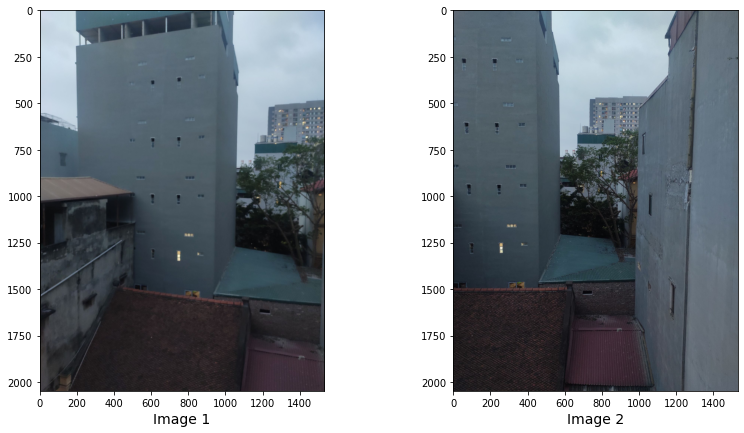

In [6]:
imgShowAll([raw1, raw2], ["Image 1", "Image 2"])

# **1. Keypoint Detection**

Convert ảnh đầu vào sang ảnh Grey Scale để giảm khối lượng tính toán cho thuật toán trong khi vẫn đảm bảo cấu trúc của ảnh được toàn vẹn (không mất đi các chi tiết quan trọng của ảnh)

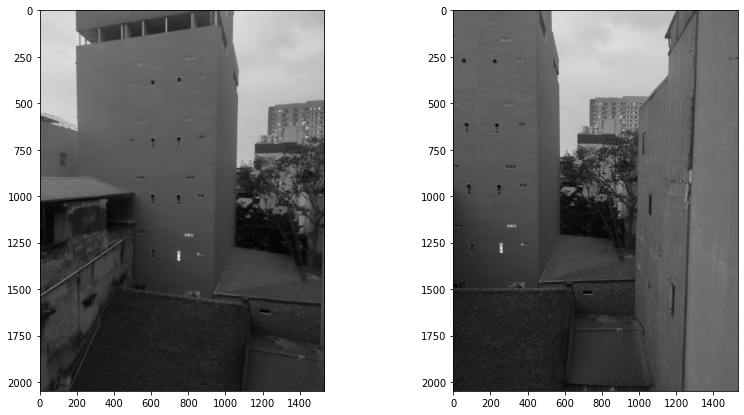

In [7]:
gray1 = cv2.cvtColor(raw1, cv2.COLOR_RGB2GRAY)
gray2 = cv2.cvtColor(raw2, cv2.COLOR_RGB2GRAY)
imgShowAll([gray1, gray2])

# Tìm keypoints
  - Sử dụng thuật toán SIFT (Scale Invariant Feature Transform) để detect các Keypoint trong ảnh
  - Keypoints là những điểm đặc biệt, đặc trưng cho riêng ảnh chủ thể
  - Thuật toán SIFT sẽ trả về **descriptor** với dạng là vector 128 chiều về đặc trưng của các **keypoint**
  - Sử dụng ảnh grey ở trên để tính toán ra các keypoint, dựa vào kết quả trả về sẽ revert lại màu cho ảnh gốc
  - Thuật toán SIFT bao gồm các bước:
    - *Scale-space extrema detection*: Được tính toán bằng cách tính gần đúng LoG (Laplace of Gaussian) dùng DoG (Difference of Gaussian)
    - *Keypoint localization*: Khi tìm được vị trí các Keypoint, chúng phải được tinh chỉnh để có kết quả chính xác hơn
    - *Orientation assignment*: Một hoặc nhiều orientation (hướng) sẽ được gắn cho từng vị trí keypoint dựa trên image gradient
    - *Keypoint descriptor*: SIFT sẽ tính Keypoint descriptor bằng cách lấy 16x16 neighborhood(điểm liền kề) của keypoint đó, rồi chia thành 16 sub-blocks với kích thước 4x4, với mỗi sub-block, ta sẽ tạo được 8 bin oritation (128 chiều)



In [8]:
def detectAndDescrible(image):
  sift = cv2.xfeatures2d.SIFT_create()
  keypoints, descriptors = sift.detectAndCompute(image, None)
  return (keypoints, descriptors)

- Xác định các keypoint, descriptors và preview lên cho từng ảnh
- Ở đây bọn em đã vẽ keypoint lên ảnh gốc dựa vào tập keypoints đã tính toán
- Như cô có thể thấy thì ở trên ảnh là các Keypoint khó bị thay đổi khi điều kiện môi trường thay đổi, các keypoint được detect khá chính xác (lùm cây, cửa sổ của tòa nhà, ...)


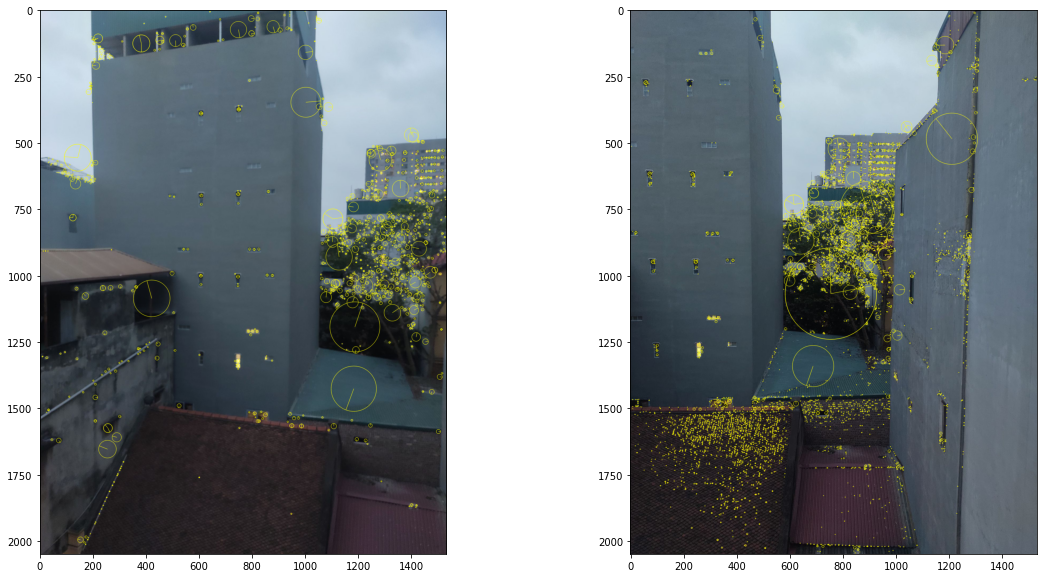

In [9]:
(keypoints1, descriptors1) = detectAndDescrible(gray1)
image1WithKeypoint = cv2.drawKeypoints(raw1, keypoints1, None, color=(255,255,0), flags=4)

(keypoints2, descriptors2) = detectAndDescrible(gray2)
image2WithKeypoint = cv2.drawKeypoints(raw2, keypoints2, None, color=(255,255,0), flags=4)

imgShowAll([image1WithKeypoint, image2WithKeypoint], size = 10)

# **2. Keypoint Matching**

# Tiến hành so khớp 2 tập keypoint của 2 ảnh
  - Người ta thường dùng **khoảng cách Euclid** giữa 2 Descriptor của 2 Keypoint để đo độ sai khác giữa 2 keypoint đó
  - Có 2 thuật toán chủ đạo để so khớp 2 tập keypoint đó là **Brute Force Matching** và **FLANN maching**
  - Nhưng ở đây bọn em sẽ sử dụng **Brute Force Matching** để cho ra kết quả tốt nhất (Tư tưởng của **Brute Force Matching** là vét cạn và tìm ra cặp keypoint giống nhau nhất giữa 2 tập, còn với **FLANN Matching** thì sẽ tìm ra cặp điểm đủ tốt, trade off giữa hiệu năng và thời gian thực thi)

In [10]:
def matcher(query_description, train_description, ratio=0.75):
  bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
  ## Bruce Force KNN trả về list gồm k ứng viên cho mỗi keypoint.
  rawMatches = bf.knnMatch(query_description, train_description, 2)
  matches = []
  for m,n in rawMatches:
      # giữ lại các cặp keypoint sao cho với kp1, khoảng cách giữa kp1 với ứng viên 1 nhỏ hơn nhiều so với khoảng cách giữa kp2 và ứng viên 2
      if m.distance < n.distance * ratio:
          matches.append(m)
  # do có cả nghìn match keypoint, ta chỉ lấy tầm 100 -> 200 cặp tốt nhất để tốc độ xử lí nhanh hơn
  matches = sorted(matches, key=lambda x: x.distance, reverse=True)
  matches = matches[:100]
  return matches

# Vẽ ra các đường nối giữa các keypoint giống nhau trong 2 ảnh
- Có thể thấy rằng các keypoint được match với nhau với độ chính xác rất cao, các line gần như song song với nhau
- Ngay cả lùm cây với tán lá cũng được match rất chuẩn xác 
- Tuy nhiên vẫn có một vài keypoint nhận diện nhầm, như gờ tường của tòa nhà phía bên tay trái được match với cành bị cụt của thân cây
- Nhưng về cơ bản, số lượng keypoint bị match nhầm là không nhiều nên không ảnh hưởng tới đầu ra của ảnh

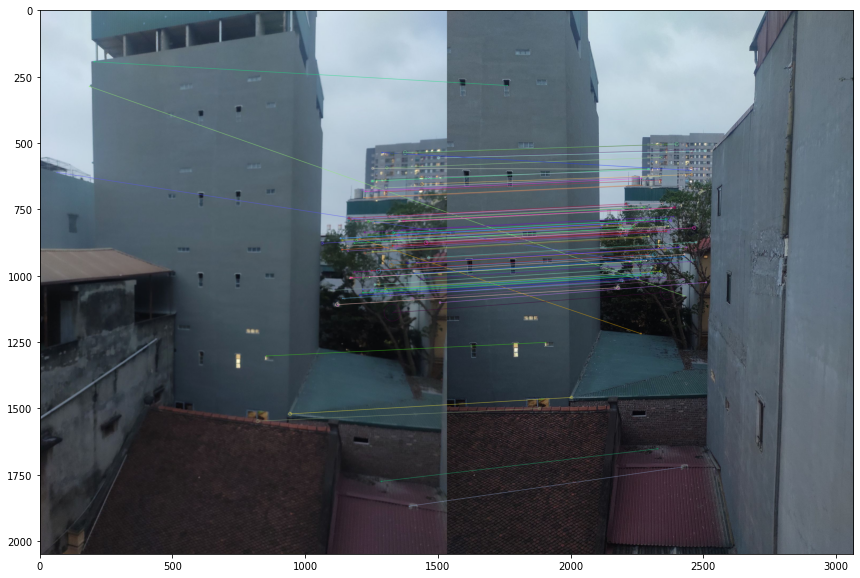

In [11]:
matches = matcher(descriptors1, descriptors2)
img3 = cv2.drawMatches(raw1, keypoints1, raw2, keypoints2, matches, None, flags= cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS + cv2.DrawMatchesFlags_DRAW_RICH_KEYPOINTS )
imgShow(img3, size=(20,10))

# **3. Perspective Transformation**
- Đầu tiên chúng em sẽ tìm ma trận các đặc trưng đồng nhất Homography Matrix
- Homography là sự dịch chuyển sử dụng phép chiếu hình học, hay nói cách khác nó là một phép biến đổi (ma trận 3 × 3) ánh xạ các điểm trong một hình ảnh sang các điểm tương ứng trong hình ảnh khác
- Có thể hiểu Homography là ma trận các điểm tương đồng giữa 2 ảnh
- Trong xử lí ảnh, các phép biến đổi ảnh như tịnh tiến, xoay, bóp méo, Affine, Perspective transform... được thực hiện bằng cách nhân ma trận trên hệ tọa độ đồng nhất - homogeneous coordinates
![image.png](https://images.viblo.asia/13c74837-e498-41de-a7ec-187409319d19.png)
- Perspective transform là 1 phép biến đổi "vi diệu", nó không bảo toàn góc, độ dài, tính song song... mà chỉ bảo toàn đường thẳng. Cũng nhờ tính chất này, perspective transform giúp biến đổi ảnh từ 1 góc chiếu này sang 1 góc chiếu khác hẳn
- **RANSAC** - Random Sample Consesus, là 1 thuật toán khá đơn giản. Trong bài toán này, RANSAC chỉ đơn giản là lấy mẫu bất kì 4 cặp điểm ngẫu nhiên, tính matrix H. Tính tổng độ sai khác giữa các điểm target và các điểm input sau khi biến đổi bằng H. 

$$Loss=\sum_{0}^{n} (distance(H*k_i,k'_i))$$


In [12]:
def findHomography(matches, src_keypoints, dst_keypoints):
  src = np.float32([kp.pt for kp in src_keypoints])
  dst = np.float32([kp.pt for kp in dst_keypoints])
  pts1 = np.float32([src[m.queryIdx] for m in matches])
  pts2 = np.float32([dst[m.trainIdx] for m in matches])

  # Tìm ma trận Homography dựa trên RANSAC
  (H, status) = cv2.findHomography(pts1, pts2, cv2.RANSAC)
  return H

- Tính ra ma trận Homography dựa trên 2 tập keypoint đã tìm được từ 2 ảnh mà matching keypoint giữa chúng
- Mục đích của ma trận Homography này là ánh xạ các keypoint đã tìm được lên ảnh mục tiêu
$$(x, y, 1) = H*(x', y', 1)$$

In [13]:
H = findHomography(matches, keypoints1, keypoints2)

# Làm cong phối cảnh (warp_perspective) dựa trên ảnh và ma trận homography
- Mục đích của việc warp_perspective là để tinh chỉnh perspective làm sao khi stitching 2 ảnh sẽ bảo toàn được các đường thẳng, tính song song mà không bị cong vênh gãy khúc

In [14]:
def warp_image(image, homography):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2BGRA)
    h, w, z = image.shape

    # Tìm tọa độ min, max của ảnh mới sau khi chiếu
    p = np.array([
      [0, w, w, 0], 
      [0, 0, h, h], 
      [1, 1, 1, 1]
    ])

    p_prime = np.dot(homography, p)

    yrow = p_prime[1] / p_prime[2]
    xrow = p_prime[0] / p_prime[2]

    ymin = min(yrow)
    xmin = min(xrow)

    ymax = max(yrow)
    xmax = max(xrow)

    # dịch chuyển về tọa độ (0,0)
    new_mat = np.array([
      [1, 0, -1 * xmin], 
      [0, 1, -1 * ymin], 
      [0, 0, 1]
    ])
    homography = np.dot(new_mat, homography)
    
    # height and width of new image frame
    height = int(round(ymax - ymin))
    width = int(round(xmax - xmin))
    size = (width, height)
    # Do the warp
    warped = cv2.warpPerspective(src=image, M=homography, dsize=size)
    return warped, (int(xmin), int(ymin))

Như cô có thể thấy, ảnh sau khi được warp_perspective thì đã cho ra các đường khá thẳng và có thể bắt đầu stitch image

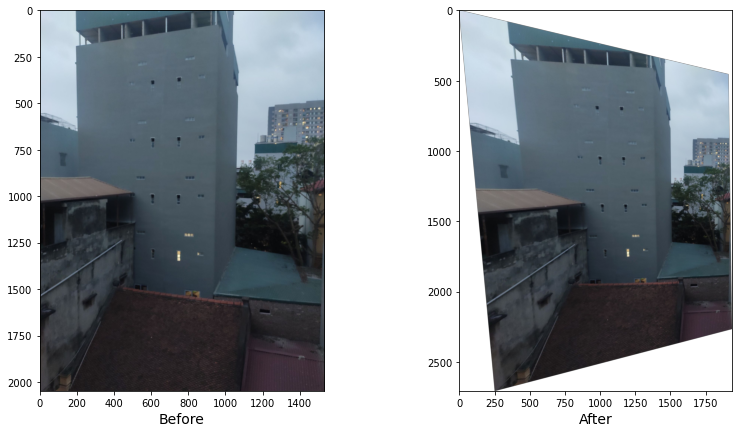

In [15]:
wrapImg,origin = warp_image(raw1, H)
imgShowAll([raw1, wrapImg], ["Before", "After"])

# **4. Stitching Image**

# Ghép ảnh
- Stack 2 image lại với nhau dựa trên các ảnh đã được biến đổi về phối cảnh (perspective), với origin là vị trí tương đối của 2 ảnh
- Tính toán offset của 2 ảnh để xác định phần chồng nhau giữa 2 ảnh
- Dịch ảnh theo offset để chồng lên nhau
 - Nếu ảnh 2 cao hơn ảnh 1 thì lùi ảnh 1 xuống
 - Tương tự với các trường hợp khác
- Có thể thấy kết quả khá tốt khi các đường được ghép với nhau rất thẳng, tuy vậy do việc biến đổi về perspective nên hình dạng của tòa nhà không được đúng cho lắm (hình thang thay vì hình chữ nhật) nhưng đây là điều có thể chấp nhận được vì nếu sửa lại perspective thì sẽ làm hỏng perspective của những vật xung quanh. Và hình dạng của tòa nhà có thể chấp nhận được 

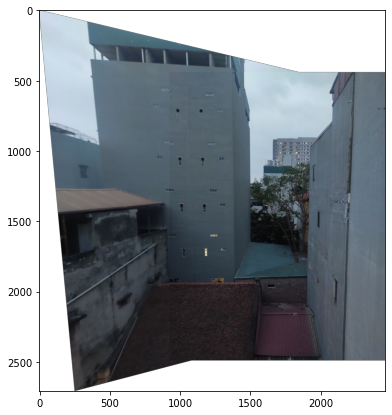

In [16]:
def stack_image(img1, img2, origin):

    img1_offset = abs(min(origin[0], 0)), abs(min(origin[1], 0))
    img2_offset = img1_offset[0] + origin[0], img1_offset[1] + origin[1]

    # fix dim
    if img1.ndim == 3:
        img1 = cv2.cvtColor (img1, cv2.COLOR_RGB2RGBA)
    if img2.ndim == 3:
        img2 = cv2.cvtColor (img2, cv2.COLOR_RGB2RGBA)
    
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]

    img1_end = img1_offset[0] + w1, img1_offset[1] + h1
    img2_end = img2_offset[0] + w2, img2_offset[1] + h2

    res_width = max(img1_end[0], img2_end[0])
    res_height = max(img1_end[1], img2_end[1])

    # print()

    result = np.zeros((res_height, res_width, 4), np.uint8)

    result[img2_offset[1]:img2_end[1], img2_offset[0]:img2_end[0]] = img2

    img1_ = list([[ img1[i,j] if img1[i,j][3] != 0 else result[i+img1_offset[1],img1_offset[0]+j] for j in range(0,w1)] for i in range(0,h1)])
    result[img1_offset[1]:img1_end[1], img1_offset[0]:img1_end[0]] = img1_
    return result, img1_offset[1]
# test
result, offset_y = stack_image(raw2, wrapImg, origin)
imgShow(result)
    

# **5. Post Processing**

# Crop Stitching Image
- Ở đây bọn em sẽ set upper và lower height của ảnh dựa vào vị trí tương đối của 2 ảnh đã được xử lý
- Với chiều rộng width thì bọn em define một ngưỡng threshhold, xác định ngưỡng black_pixel là 1% pixel chiều cao của ảnh, scan ảnh, và cắt theo ngưỡng đã xác định
- Với 2 ảnh ghép lại với nhau thì việc crop khá ổn, không mất đi quá nhiều chi tiết trong khi vẫn đảm bảo thông tin cho ảnh tức là không bị mất các chi tiết

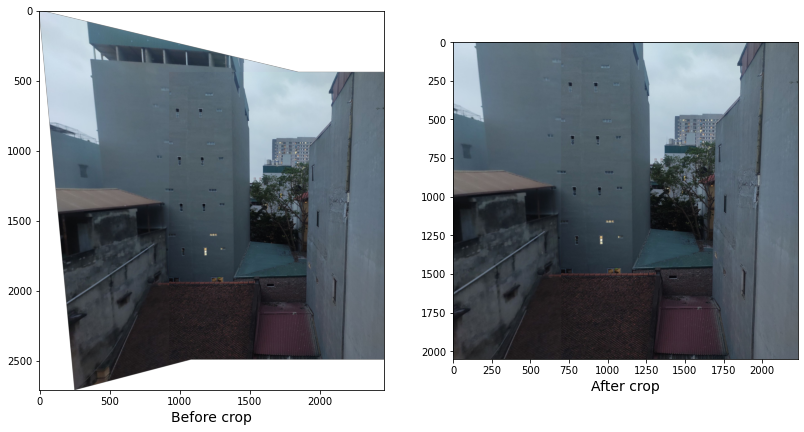

In [17]:
def crop(img, origin = None):
    upper, lower = [0, img.shape[0]]
    left, right = [0, img.shape[1]]
    if origin is not None:
        upper = origin[0]
        lower = origin[1]
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)[1]
    # imgShow(thresh)

    thresh = thresh[upper:lower, :]

    black_pixel_num_threshold = img.shape[0]//100
    scan = True
    while scan and black_pixel_num_threshold < img.shape[0]:
        for x in range(thresh.shape[1]):
            if np.count_nonzero(thresh[:,x]==0) < black_pixel_num_threshold:
                left = x
                scan = False
                break
        black_pixel_num_threshold*=1.5

    black_pixel_num_threshold = img.shape[0]//100
    scan = True
    while scan and black_pixel_num_threshold < img.shape[0]:
        for x in range(thresh.shape[1]-1, 0, -1):
            if np.count_nonzero(thresh[:,x] == 0) < black_pixel_num_threshold:
                right = x
                scan = False
                break
        black_pixel_num_threshold*=1.5
    return  img[upper:lower,left:right]

imgShowAll([result,crop(result, (offset_y, offset_y+h1))], ["Before crop", "After crop"])
# imgShowAll([test2,crop(test2)], ["Before crop", "After crop"])

# **Test với một list các ảnh**
- Xác định hàm trả về ma trận Homography cho 2 ảnh
- Xác định hàm createPano() với đầu vào là một list các ảnh, có 3 mode tùy chọn là "center", left-to-right (L2R) và right-to-left (R2L)
- 3 Mode là thứ tự stitching các ảnh
 - "center": Ghép các ảnh bên vào ảnh giữa trong đó ảnh ở giữa được toàn vẹn
 - "L2R: Ảnh đầu tiên được toàn vẹn trong khi những ảnh còn lại được warp_perspective
 - "R2L": Ảnh cuối được toàn vẹn trong khi những ảnh đầu tiên được warp_perspective

In [18]:
def getHomography(img1, img2):
    # convert to gray scale
    gray1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)
    # find keypoint and descriptors
    (keypoints1, descriptors1) = detectAndDescrible(gray1) 
    (keypoints2, descriptors2) = detectAndDescrible(gray2)
    # matcher
    matches = matcher(descriptors1, descriptors2)
    # find homography
    homography_matrix = findHomography(matches, keypoints1, keypoints2)
    return homography_matrix
  
def createPano(images, mode='center'):
    if mode == 'center':
        center_idx = (len(images) -1 ) // 2 
        left = list(range(0, center_idx))
        right = list(range(center_idx + 1, len(images)))
        order = [center_idx] + right + left
    elif mode == 'L2R':
        order = list(range(0, len(images)))
    elif mode == 'R2L':               
        order = list(range(0, len(images)))[::-1]

    offset_all = 0;
    center_height = 0;
    for idx,i in enumerate(order):
        if idx == 0:
            result = images[i]
            center_height = images[i].shape[0]
        else:
            homography_matrix = getHomography(images[i], result)
            wrap_img, origin = warp_image(images[i], homography_matrix)
            result, offset = stack_image(result, wrap_img, origin)
            offset_all += offset
    return result, (offset_all, offset_all+center_height)

# Tạo ảnh với các mode khác nhau và init giá trị origin là vị trí tương đối của các cặp ảnh

In [19]:
img11 = imageio.imread('set1/1.jpg')
img12 = imageio.imread('set1/2.jpg')
img13 = imageio.imread('set1/3.jpg')

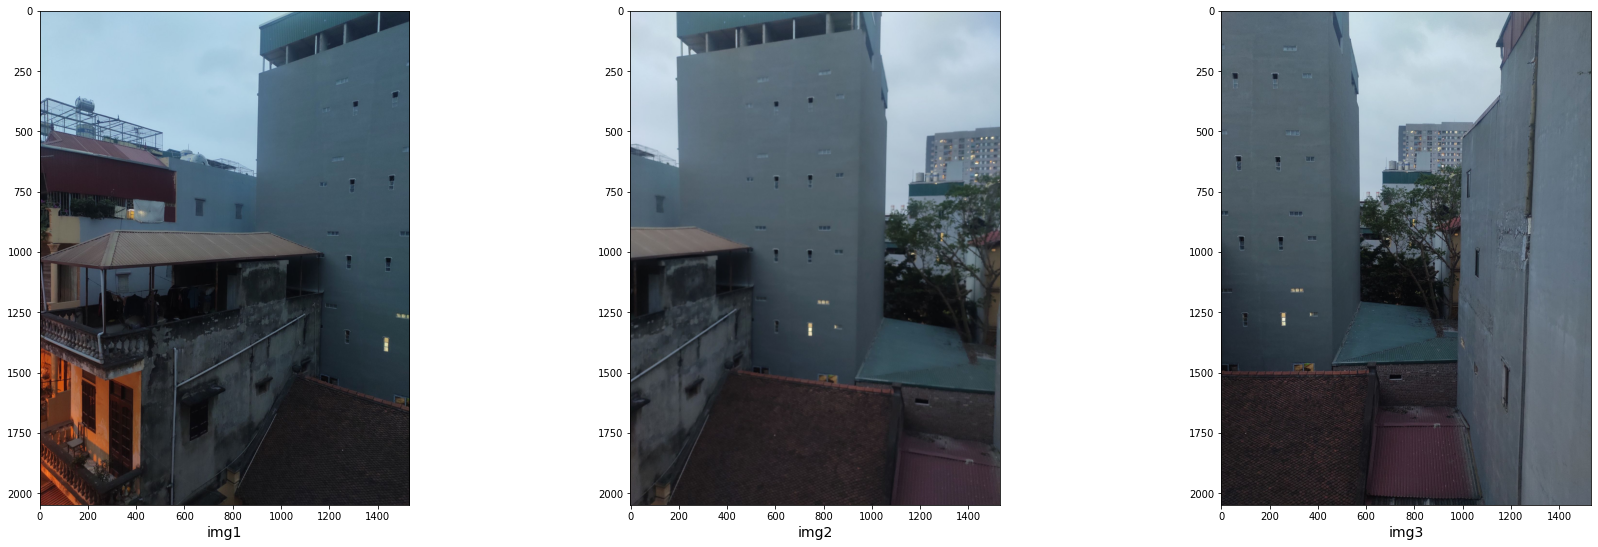

In [20]:
imgShowAll([img11,img12,img13],["img1", "img2", "img3"], size = 10)

test1, origin1 = createPano([img11, img12, img13], mode='L2R')
test2, origin2 = createPano([img11, img12, img13], mode='center')
test3, origin3 = createPano([img11, img12, img13], mode='R2L')

- Với mode "L2R" thì có thể thấy ảnh bị skew khá nhiều, cảm giác height của ảnh khá thấp nhưng độ rộng của ảnh lại thu lại được nhiều
- Sự ảnh hưởng này là do hàm warp_perspective, khi ảnh thứ 2 được warp_perspective theo ảnh 1, và ảnh 3 được warp_perspective theo ảnh 2 nên ảnh sẽ được scale về chiều rộng

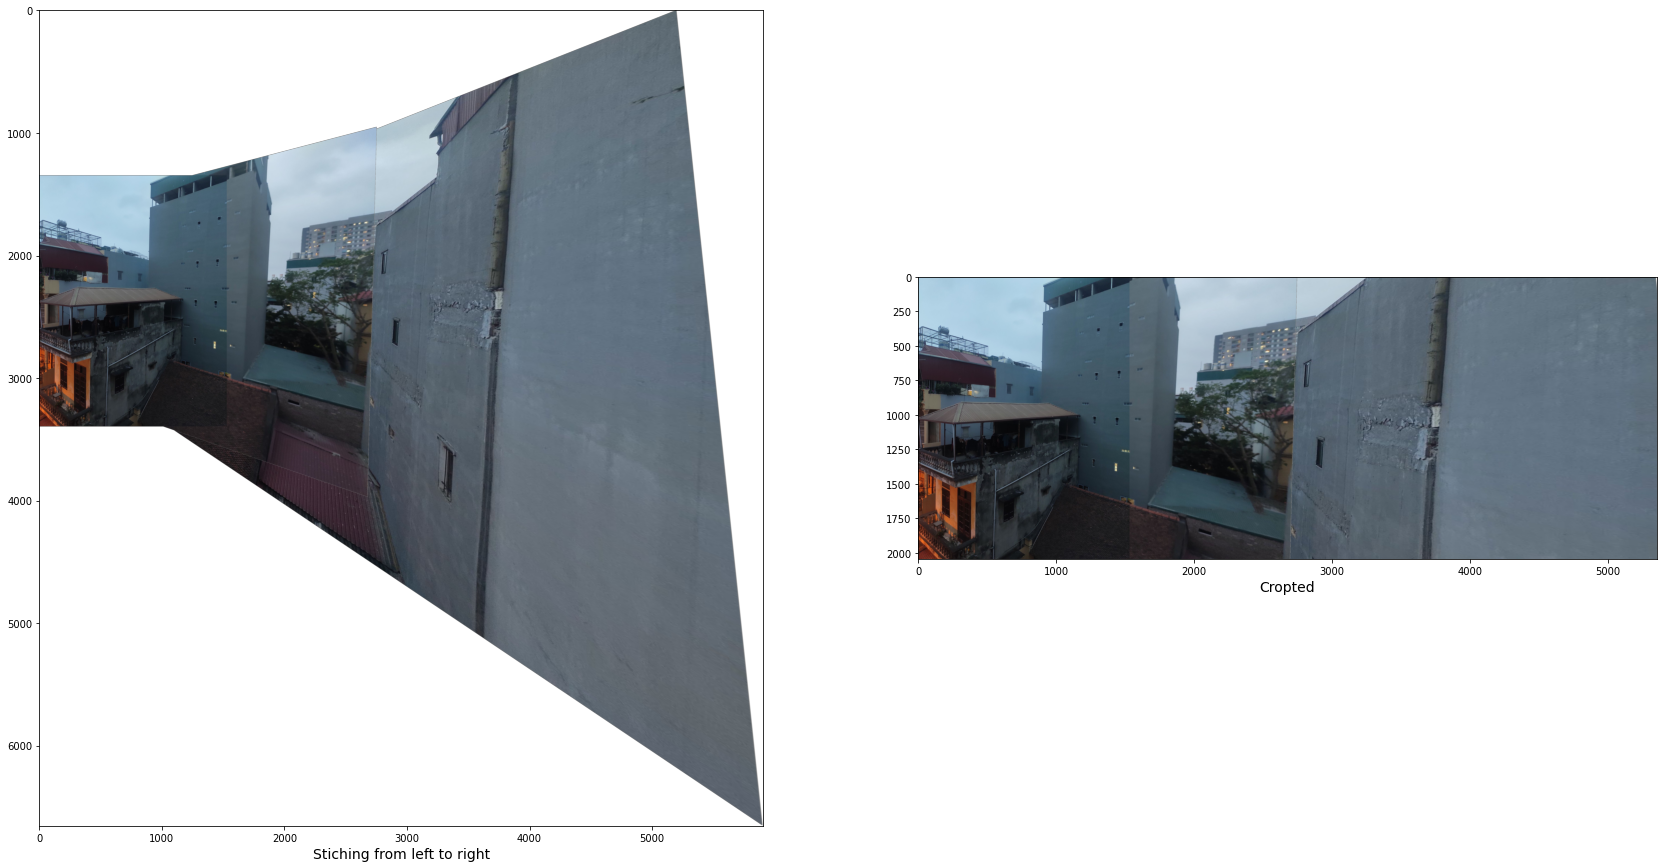

In [21]:
imgShowAll([test1, crop(test1, origin1)], ["Stiching from left to right", "Cropted"], size=15)

- Với mode "center" thì ảnh không bị biến đổi nhiều, sự chênh lệch không lớn giữa các ảnh,cảm giác height của ảnh khá cao nhưng độ rộng của ảnh lại thu lại được không nhiều do hiệu ứng warp_perspective dàn đều phối cảnh của 2 ảnh bên
- Sự ảnh hưởng này là do hàm warp_perspective

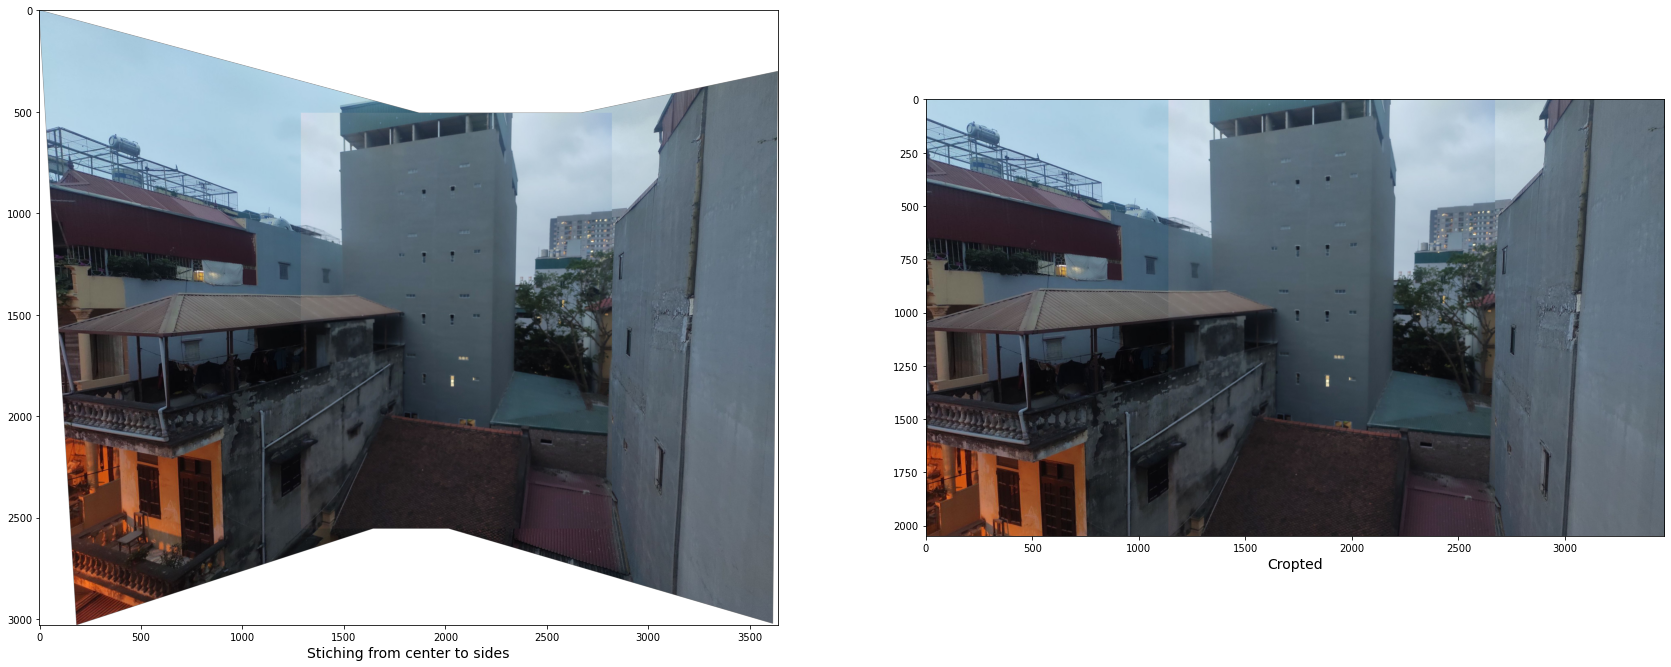

In [22]:
imgShowAll([test2, crop(test2, origin2)], ["Stiching from center to sides", "Cropted"] ,size=15)

- Với mode "R2L" thì có thể thấy ảnh bị skew khá nhiều, cảm giác height của ảnh khá thấp nhưng độ rộng của ảnh lại thu lại được nhiều
- Sự ảnh hưởng này là do hàm warp_perspective, khi ảnh thứ 2 được warp_perspective theo ảnh 3, và ảnh 1 được warp_perspective theo ảnh 2 nên ảnh sẽ được scale về chiều rộng
- Tuy nhiên có thể thấy do ảnh 1 bị warp_perspective khá nhiều nên cấu trúc của ảnh đã biến đổi, các tòa nhà không được bảo toàn về cấu trúc nên ảnh bị ngả nghiêng khá nhiều, các cột nhà không được thẳng mà xuất hiện tình trạng xiên chéo

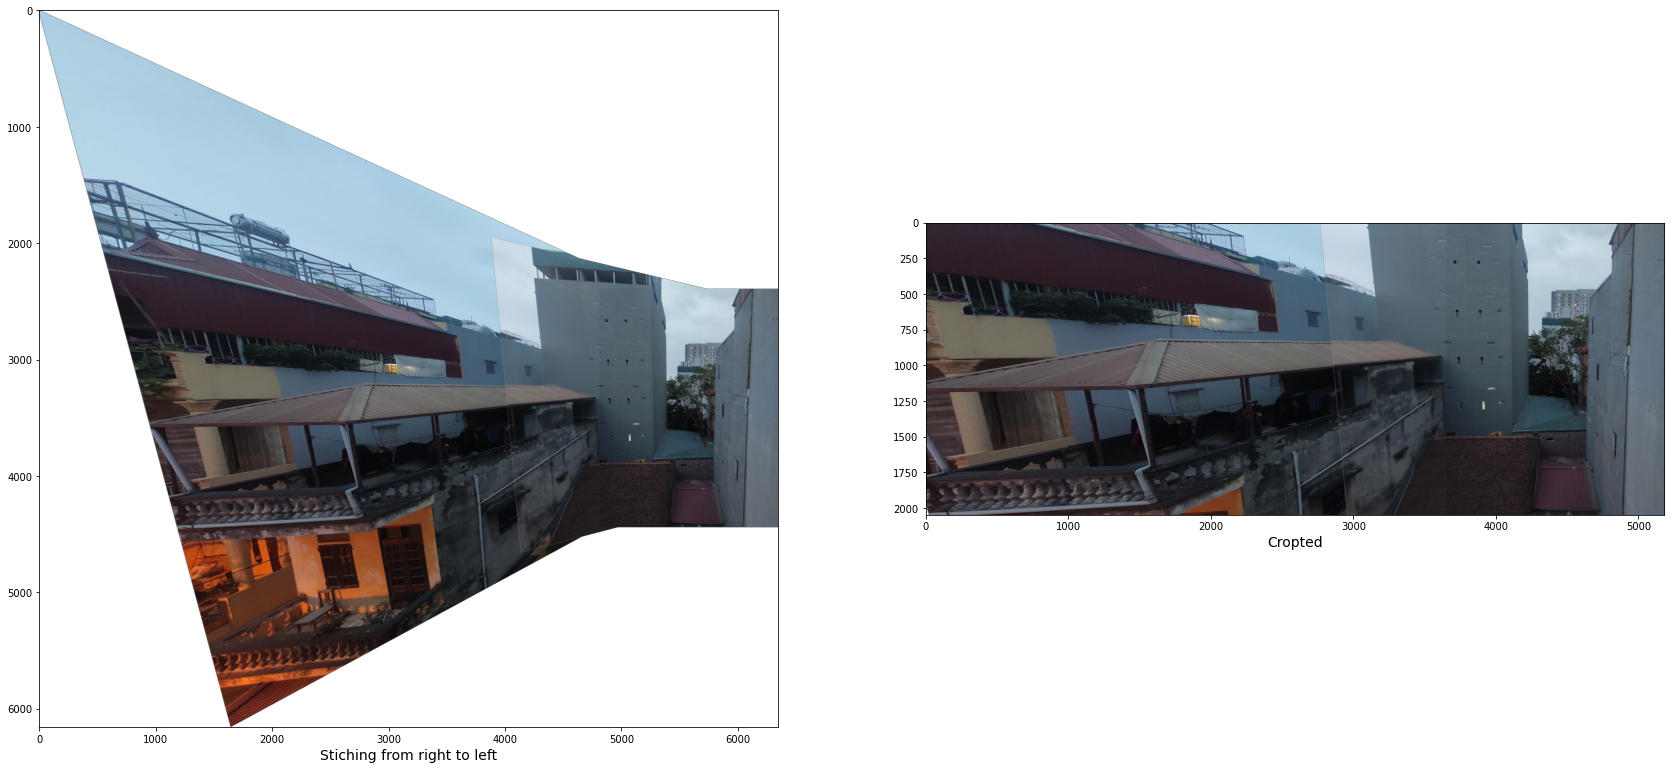

In [23]:
imgShowAll([test3, crop(test3, origin3)], ["Stiching from right to left", "Cropted"], size=15)

# **Kết Luận**
Qua 3 mode trên ta có thể rút ra kết luận mode "center" cho ra hiệu quả là tốt nhất khi mà ảnh không bị biến đổi về perspective quá nhiều và cấu trúc các vật thể trong ảnh khá toàn vẹn

# Thử nghiệm với ảnh có người, ít các đường thẳng và nhiều chi tiết 

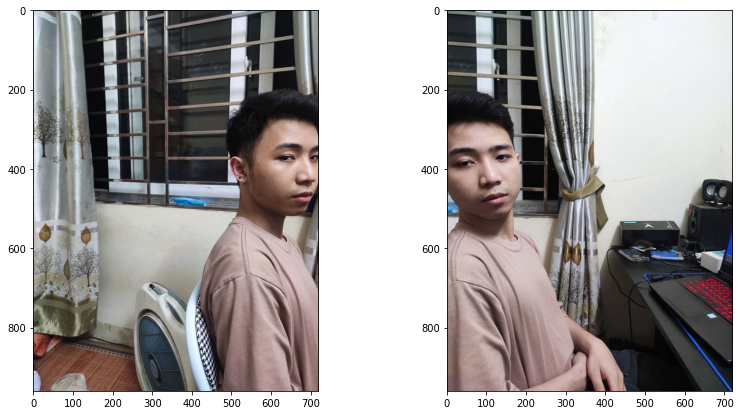

In [29]:
img31 = imageio.imread('set3/1.jpg')
img32 = imageio.imread('set3/2.jpg')
imgShowAll([img31,img32])
test6, origin6 = createPano([img31, img32], mode='center')
test7, origin7 = createPano([img31, img32], mode='R2L')

- Có thể thấy, ảnh được stitching khá tốt, ít có sự biến đổi về perspective, tuy nhiên ở điểm cắt cảu 2 ảnh, tức là khuôn mặt của anh chàng ở trên thì theo cảm quan của người nhìn, ảnh được ghép khá thô, cho thấy ma trận homography cho ra các keypoint không được match với nhau chuẩn chỉ

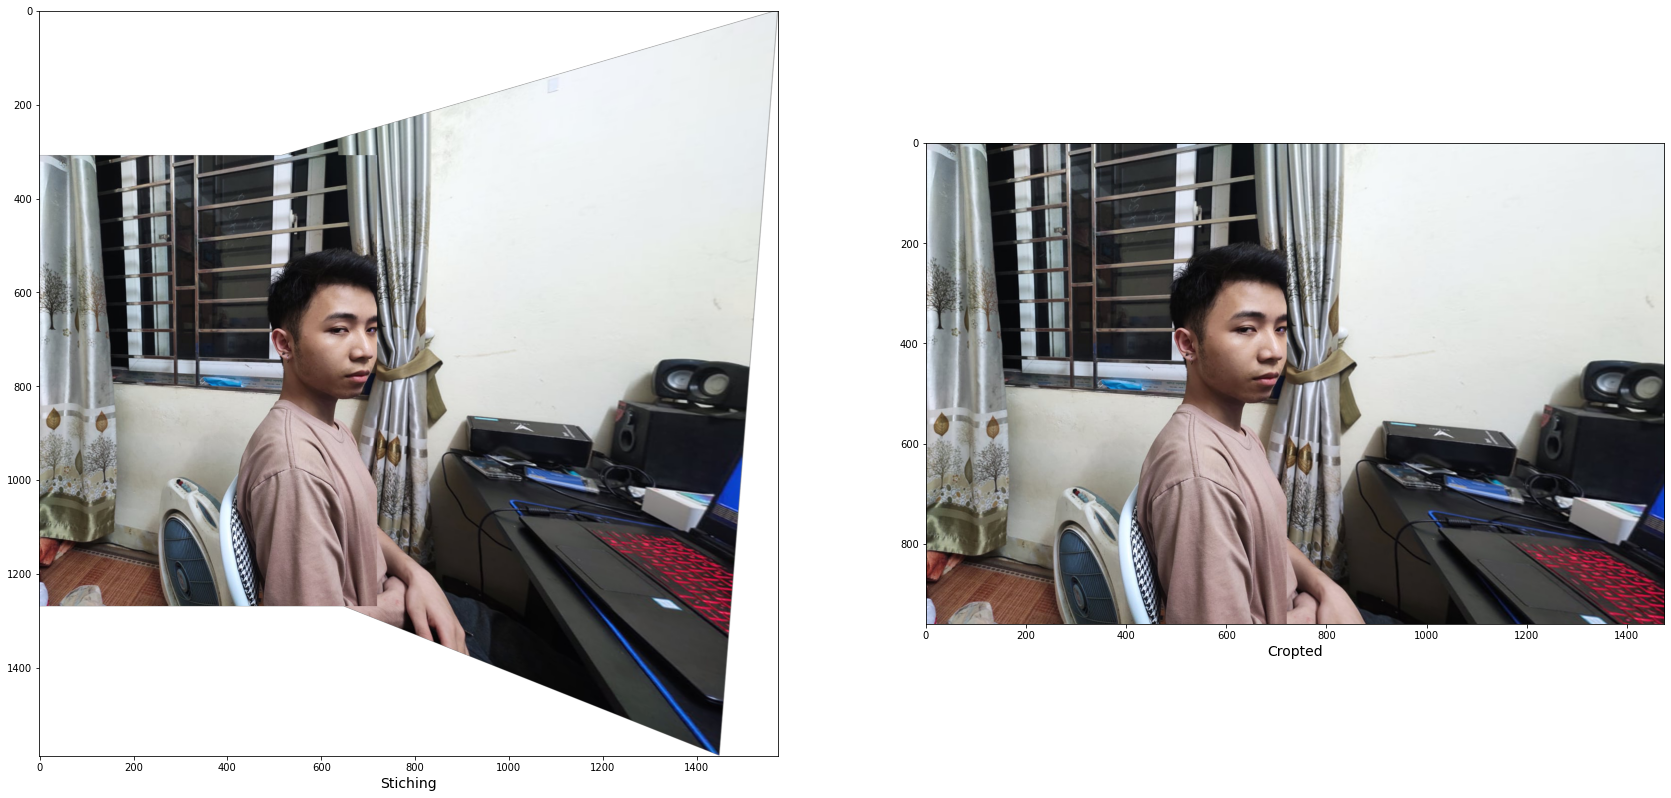

In [30]:
imgShowAll([test6, crop(test6, origin6)], ["Stiching", "Cropted"], size=15)

- Khi stitching image với mode R2L thì thuật toán cho ra ảnh không hoàn chỉnh, khi mà phần khuôn mặt của anh chàng bị cắt đột ngột và mất một phần chi tiết
- Họa tiết của cái cây trên chiếc rèm bị scale quá nhiều do hiệu ứng khi warp_perspective

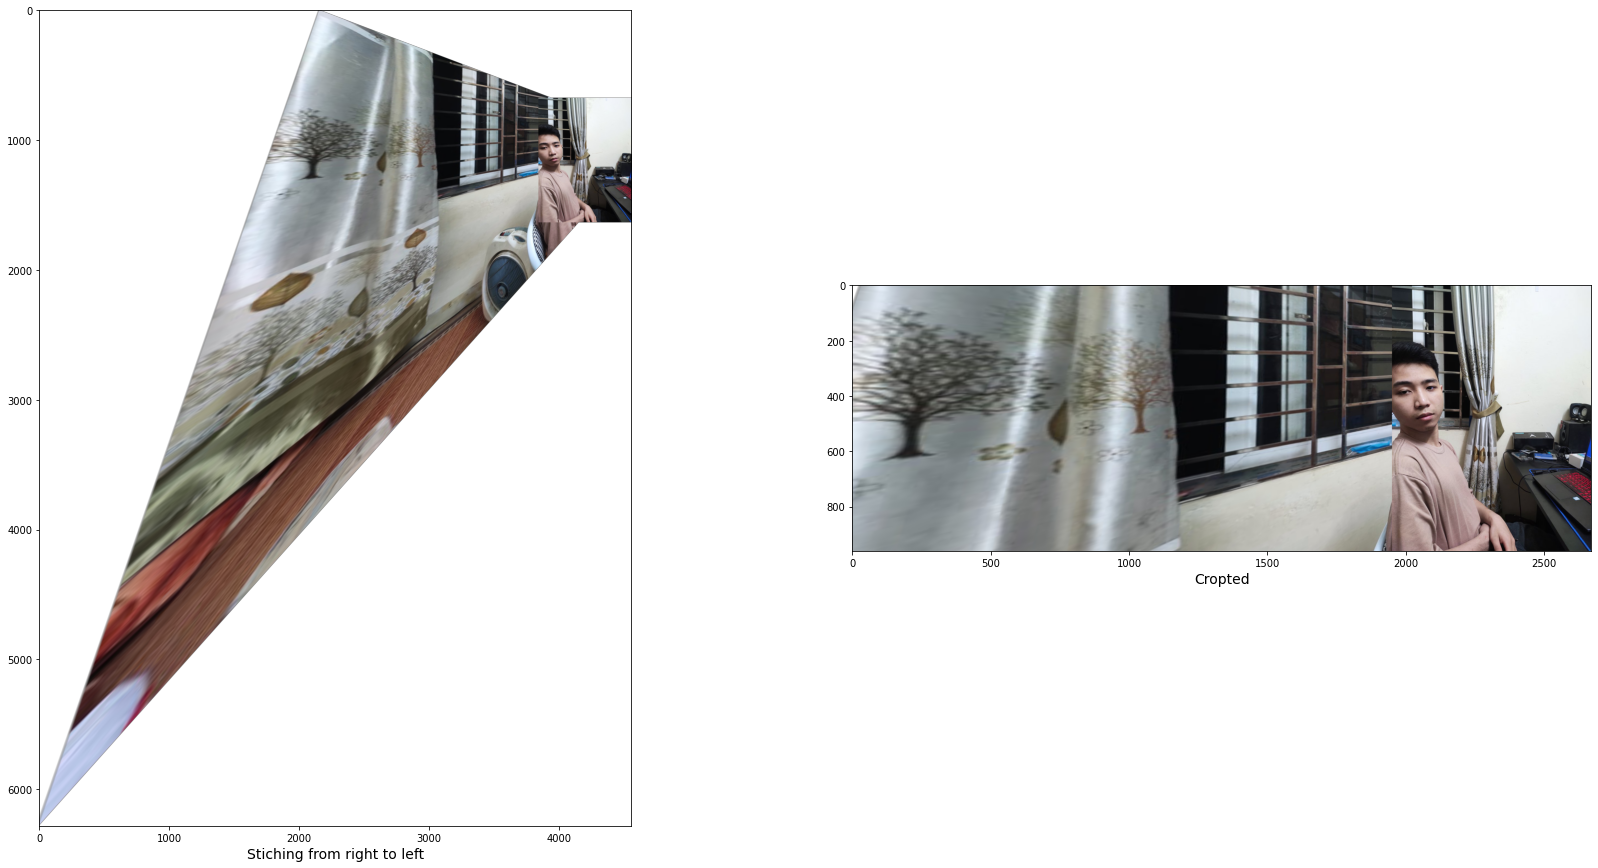

In [31]:
imgShowAll([test7, crop(test7, origin7)], ["Stiching from right to left", "Cropted"], size=15)